### 이항 분류, CPU
#### 표준화를 사용: country1.csv
- 평균 -> 편차 -> 편차의 제곱의 평균(분산) -> 표준 편차 -> 표준화(z) -> 표준정규분포

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
# import cv2
import random

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import font_manager, rc

import platform 
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):  
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/dnn/country' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
plt.rcParams["figure.figsize"] = (6, 3) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
    
# ---------------------------------------------------------------------

In [2]:
# 데이터 준비
data = np.loadtxt('./country2.csv', delimiter=',', dtype=np.float64, skiprows=1)
print(type(data))
print(data.shape)
print(data)

<class 'numpy.ndarray'>
(100, 7)
[[ 0.  0.  0.  5.  1.  0.  0.]
 [ 1.  0.  1.  6.  1.  0.  1.]
 [ 1.  1.  1. 10.  1.  0.  1.]
 [ 0.  0.  0. 10.  1.  0.  0.]
 [ 1.  0.  1. 10.  1.  2.  1.]
 [ 1.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  5.  1.  0.  0.]
 [ 1.  0.  1.  6.  1.  0.  1.]
 [ 1.  1.  1. 10.  1.  3.  1.]
 [ 1.  0.  1.  2.  1.  1.  0.]
 [ 0.  1.  1. 10.  1.  3.  1.]
 [ 1.  0.  1. 10.  1.  3.  1.]
 [ 0.  0.  0.  5.  1.  0.  0.]
 [ 1.  0.  1.  6.  1.  0.  1.]
 [ 1.  1.  1. 10.  1.  1.  1.]
 [ 0.  0.  0. 10.  1.  1.  0.]
 [ 1.  0.  1. 10.  1.  3.  1.]
 [ 1.  1.  0. 10.  1.  3.  1.]
 [ 0.  0.  0.  5.  1.  0.  0.]
 [ 1.  0.  1.  6.  1.  0.  1.]
 [ 1.  1.  1. 10.  1.  1.  1.]
 [ 1.  0.  0.  3.  0.  1.  0.]
 [ 1.  1.  0. 10.  1.  3.  1.]
 [ 1.  1.  1. 10.  1.  2.  1.]
 [ 0.  0.  0.  5.  1.  0.  0.]
 [ 1.  0.  1.  6.  1.  0.  1.]
 [ 1.  0.  1. 10.  1.  3.  1.]
 [ 1.  1.  0.  7.  1.  0.  0.]
 [ 0.  0.  1. 10.  1.  1.  0.]
 [ 1.  1.  1. 10.  1.  3.  1.]
 [ 0.  0.  0.  5.  1.  0.  0.]
 [ 1. 

In [3]:
# 평균, 표준 편차의 산출시 행방향 기준이 아니라 열방향을 기준으로 산출해야함.
# 성  명  Python  Tensorflow  Analysis
# 왕눈이  90      80            90  
# 아로미  95      90            85  
# 투투    80      65            75
# Python 과목의 평균과 표준편차는 열방향으로 구해야하나, 
# 일반적인 관측치 데이터는 행방향을 가지고 있음

print(data.shape)
datat = data.T
print(datat.shape)

(100, 7)
(7, 100)


In [4]:
np.sqrt(np.var(datat[2]))

0.4737087712930805

In [5]:
# 표준화, 연속실행 안됨 ★
print(range(len(datat)))
print(range(len(datat)-1)) # 7번째 행은 분류라 제외(아래 for문에서 -1로 제외)


range(0, 7)
range(0, 6)


In [6]:

# print(datat)
ms = [] # 평균 목록, 테스트시 사용
stds = [] # 표준편차 목록, 테스트시 사용
for i in range(len(datat)-1): # 6개의 행 대상, Target 컬럼 7번째 컬럼은 제외
    # datat[i] = datat[i].astype('float32')
    m = datat[i].mean()  # 평균
    std = datat[i].std() # 표준편차
    print(i, '행 ''m:', m, ' std:', std)
    
    # 표준화 실행, 평균(m) 0, 분산 1, 표준편차: std
    datat[i] = (datat[i] - m) / std # z 값

    ms.append(m)     # 모델 사용시에 사용
    stds.append(std) # 모델 사용시에 사용

# print(datat[5])


0 행 m: 0.8  std: 1.0295630140987002
1 행 m: 0.39  std: 0.4877499359302879
2 행 m: 0.66  std: 0.4737087712930805
3 행 m: 7.32  std: 2.842111890830479
4 행 m: 0.92  std: 0.2712931993250107
5 행 m: 1.19  std: 1.2385071659057931


In [7]:
data = datat.T     # 행과열을 처음 상태로 복원
print(data.shape)
print(data[0])

(100, 7)
[-0.77702869 -0.79959006 -1.39326109 -0.81629439  0.29488391 -0.96083417
  0.        ]


In [8]:
# 데이터가 정렬이 안된경우 사용 가능
# 훈련용 + 검증용: 90 건

# 테스트용: 10 건
# 데이터가 정렬이 안된경우 사용 가능
# 훈련용 + 검증용: 90 건
X = data[:, :6]
print(X[:3])
Y = data[:, 6]
print(Y[:3])
# 테스트용: 10 건

x_train, x_test, y_train, y_test, = train_test_split(X, Y, test_size=0.1, shuffle=True)
print(x_train.shape)    # 훈련+검증 1314개, 9개 컬럼(독립변수)
print(x_test.shape)     # 테스트 146개, 9개 컬럼(독립변수)
print(y_train.shape)    # 훈련+검증 1314개, 1개 컬럼(종속변수) -> SalePrice
print(y_test.shape)     # 테스트 146개, 1개 컬럼(종속변수) -> SalePrice



[[-0.77702869 -0.79959006 -1.39326109 -0.81629439  0.29488391 -0.96083417]
 [ 0.19425717 -0.79959006  0.71774056 -0.46444336  0.29488391 -0.96083417]
 [ 0.19425717  1.25064086  0.71774056  0.94296076  0.29488391 -0.96083417]]
[0. 1. 1.]
(90, 6)
(10, 6)
(90,)
(10,)


In [9]:
# 네트워크 설계
# node, epoch, batch_size
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

model = Sequential()

model.add(Dense(300, input_dim=6, activation='relu', name = 'layer1'))
model.add(Dense(200, activation='relu', name = 'layer2'))
model.add(Dense(100, activation='relu', name = 'layer3'))
model.add(Dense(50, activation='relu', name = 'layer4'))
model.add(Dense(1, activation='sigmoid', name = 'layer5'))
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy']) 
model.summary()

# patience=5: 손실이 5번 늘어날때까지 훈련을 계속, 5번째 종료
# restore_best_weights=True: 가중치를 가장 오차가 적었던 경우로 저장
es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR): # 폴더가 존재하지 않으면 생성
    os.mkdir(MODEL_DIR) # 폴더 생성

# 03d: 좌측 0 padding 정수 3자리, .4f: 실수 소수점 4자리 
modelpath='./model/{epoch:03d}-{val_accuracy:.4f}.h5'  
# epoch:03d: 부족한 자리를 0으로 채우는 정수 형식
# val_accuracy:.4f: 소수이하 4째자리까지 표현 형식

# 검증 정확도가 개선되었을 때만 학습 모델 파일로 저장
# filepath=modelpath: 파일이 저장되는 경로와 파일명
# monitor='val_accuracy': 검증 정확도 기준으로 판단
# verbose=1: 기록되는 파일 정보 출력
# save_best_only=True: 검증 정확도가 개선되면 파일로 저장
mcp= ModelCheckpoint(filepath=modelpath,
                    monitor='val_accuracy',
                    verbose=1, save_best_only=True)

hist = model.fit(x_train, y_train, 
                    validation_split=0.2, shuffle=True, 
                    epochs=10, batch_size=10 , callbacks=[es, mcp])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 300)               2100      
                                                                 
 layer2 (Dense)              (None, 200)               60200     
                                                                 
 layer3 (Dense)              (None, 100)               20100     
                                                                 
 layer4 (Dense)              (None, 50)                5050      
                                                                 
 layer5 (Dense)              (None, 1)                 51        
                                                                 
Total params: 87,501
Trainable params: 87,501
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
1/8 [==>...........................] - ETA: 3s - loss: 0.6848 - accuracy: 0.6000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to ./model\001-1.0000.h5
8/8 [==============================] - 1s 30ms/step - loss: 0.6365 - accuracy: 0.6389 - val_loss: 0.5344 - val_accuracy: 1.0000
Epoch 2/10
1/8 [==>...........................] - ETA: 0s - loss: 0.4394 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
8/8 [==============================] - 0s 6ms/step - loss: 0.4440 - accuracy: 0.9722 - val_loss: 0.3362 - val_accuracy: 1.0000
Epoch 3/10
1/8 [==>...........................] - ETA: 0s - loss: 0.3308 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
8/8 [==============================] - 0s 6ms/step - loss: 0.2854 - accuracy: 0.9583 - val_loss: 0.1451 - val_accuracy: 1.0000
Epoch 4/10
1/8 [==>...........................] - ETA: 0s - loss: 0.1733 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 1.00000
8/8 [=

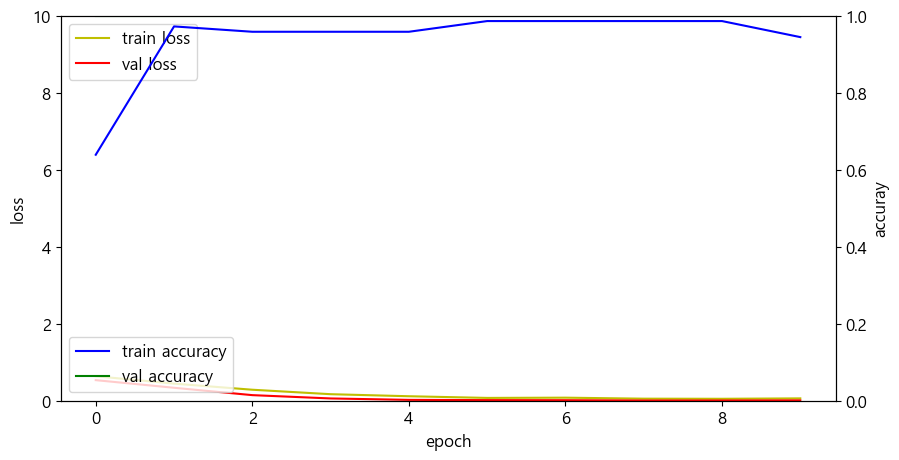

In [14]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

loss_ax.plot(hist.history['loss'], 'y', label='train loss')   # 훈련 손실
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss') # 검증 손실, 학습의 우수성 평가 척도
loss_ax.set_ylim([0.0, 10]) # 왼쪽 y 축, 값을 반영하여 변경

acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')   # 훈련 정확도
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy') # 검증 정확도
acc_ax.set_ylim([0.0, 1.0])  # 오른쪽 y 축, 0 ~100 %를 의미

loss_ax.set_xlabel('epoch')  # x축 레이블
loss_ax.set_ylabel('loss')     # 왼쪽 y 레이블
acc_ax.set_ylabel('accuray') # 오른쪽 y 레이블

loss_ax.legend(loc='upper left')  # 좌측 y 축 기준 범례 위치 설정
acc_ax.legend(loc='lower left')   # 우측 y 축 기준 범례 위치 설정

plt.show()

In [15]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')
# Country1.csv:        손실값: 0.32279130816459656 /정확도: 80.0000011920929 %
# Country2.csv:        손실값: 0.07252821326255798 /정확도: 100.0 %
# Country1.csv 표준화: 손실값: 0.0017746156081557274 /정확도: 100.0 %

손실값: 0.8130480647087097 /정확도: 89.99999761581421 %


In [16]:
# 1) 주당 음주 횟수: 0 ~ 3(3회 이상)
# 2) 농촌에서 생활적이 있다: 0(없음), 1(있음)
# 3) 가족중에 농촌에서 생활하고 있는 친척있는 여부: 0(없음), 1(있음)
# 4) 1년동안의 여행 횟수: 0 ~ 12
#     (12이상, 교통을 이용한 등산/캠핑, 당일, 국내, 국외 모두 해당)
# 5) 집을 소유 할 수 있는 경제력: 0(없음), 1(있음)
# 6) 경작 할 수 있는 토지 평수: 0 ~ (평)
#     0: 없음, 1: 1 ~ 2000 미만, 2: 2000이상 ~ 3000미만, 3: 3000 이상
# 7) 정착: 1, 실패: 0
        
drink = int(input('주당 음주 횟수는 (0 ~ 3(3회 이상)):'))
life = int(input('농촌에서 생활한 경험(0(없음), 1(있음)):'))
life2 = int(input('가족중에 농촌에서 생활하고 있는 친척있는 여부(0(없음), 1(있음)):'))
trip = int(input('1년동안의 여행 횟수(0 ~ 12):'))
house = int(input('집을 소유 할 수 있는 경제력(0(없음), 1(있음)):'))
land = int(input('경작 할 수 있는 토지 평수(0: 없음, 1: 1 ~ 2000 미만, 2: 2000이상 ~ 3000미만, 3: 3000 이상):'))

In [17]:
# 모집단의 평균과 표준편차를 이용하여 테스트 데이터의 표준화 진행 ★
data = []
data.append((drink - ms[0]) / stds[0])
data.append((life - ms[1]) / stds[1])
data.append((life2 - ms[2]) / stds[2])
data.append((trip - ms[3]) / stds[3])
data.append((house - ms[4]) / stds[4])
data.append((land - ms[5]) / stds[5])

x = np.array([
             data,
      ])
print(x.shape)
print(x)

(1, 6)
[[-0.77702869 -0.79959006 -1.39326109 -2.57554955 -3.39116499 -0.96083417]]


In [18]:
yp = model.predict(x)
print(yp)
print(yp.shape)

for i in range(len(x)):
    # print('적응 확률:', yp[i][0] * 100, ' %')
    print('적응 확률: {0:.3f}%'.format(yp[i][0] * 100))
    
    if yp[i][0] >= 0.5:    # 기존 사례를 참고하여 결정
        print('시골형: 시골에 적응 할 수 있습니다.')
    else:
        print('도시형: 시골에 적응이 불가능합니다.')

[[4.2365816e-10]]
(1, 1)
적응 확률: 0.000%
도시형: 시골에 적응이 불가능합니다.


In [19]:
# 모든 데이터를 통으로 입력받은 경우
# 2,1,1,0,3,1,0
# 2,1,1,1,3,1,0
# 2,1,1,1,3,1,1
# 2,1,1,1,6,1,1
total = input('모든 데이터를 통으로 입력:')
total_split = np.array(total.split(','), dtype=float)
data = []
data.append((total_split[0] - ms[0]) / stds[0])
data.append((total_split[1] - ms[1]) / stds[1])
data.append((total_split[2] - ms[2]) / stds[2])
data.append((total_split[3] - ms[3]) / stds[3])
data.append((total_split[4] - ms[4]) / stds[4])
data.append((total_split[5] - ms[5]) / stds[5])

x = np.array([
             data,
      ])

yp = model.predict(x)

for i in range(len(x)):
    # print('적응 확률:', yp[i][0] * 100, ' %')
    print('적응 확률: {0:.3f}%'.format(yp[i][0] * 100))
    
    if yp[i][0] >= 0.5:    # 기존 사례를 참고하여 결정
        print('시골형: 시골에 적응 할 수 있습니다.')
    else:
        print('도시형: 시골에 적응이 불가능합니다.')

ValueError: could not convert string to float: ''

In [ ]:
# y = aX + b에서 데이터를 읽고 오차가 가장 작은 a, b를 찾는 과정을
# 머신러닝이라고함.
# 데이터의 규칙(패턴)을 발견하고 최적의 a, b를 찾게됨.
# 모델(a: 기울기, b: y 절편)이 발견되면 새로운 X를 대입하여 y를 예측 할 수 있음. 

# - 하나의 변수에 대한 것은 y = a1X1 + b 로 예측 가능
# - 2개이상의 변수 y = a1*X1 + a2*X2 + b 로 해결 가능
# - 3개이상의 변수 y = a1*X1 + a2*X2 + a3*X3 + b 로 해결 가능
# - 관계형 데이터베이스의 변수(컬럼)는 보통 10 ~ 20개 이상임으로 
# - 개발자가 직접 선형회귀 구현 어려움

# 선형회귀를 이용한 도시형/귀촌/귀농에 성공한 사람들의 패턴을 파악하여 고객 진단
# - 시골에 가족(친척)이 있는지 여부
# - 시골에서 생활한 경험
# - 자택 소유
# - 토지
# - 1년의 여행 횟수
# - 음주 횟수
# - 운전면허 소유 여부
# - 차량 소유 여부
# - 성격
# - 성별
# - 판정(도시형/주말 펜션/귀촌/귀농), class

# 머신러닝은 선형회귀/분류 알고리즘을 이용하여 도시형인지 시골형인지 진단
# 딥러닝 신경망(회귀)에 기반하여 도시형인지 시골형인지 진단